In [1]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import brier_score_loss
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns

# Create Datasets

In [2]:
def make_df(f: str, cols = None, gender = False) -> pd.DataFrame:
    l = []
    for dirname, _, filenames in os.walk("/kaggle/input"):
        for filename in filenames:
            path = Path(os.path.join(dirname, filename))
            if path.stem[1:] == f:
                if cols is not None:
                    df = pd.read_csv(path, index_col = None, usecols = cols)
                else:
                    df = pd.read_csv(path, index_col = None)
                if gender:
                    df["Gender"] = path.stem[0]
                l.append(df)
    return pd.concat(l, axis=0, ignore_index=True)


def double_merge(main: pd.DataFrame, supplementary: pd.DataFrame, how = "left") -> pd.DataFrame:
    '''
    used to merge two sets of team info per row (matchup)
    '''
    df = main.merge(supplementary, 
               left_on = ["Season","LowerTeamID"],
               right_on = ["Season","TeamID"], how=how).merge(
        supplementary, 
        left_on = ["Season","HigherTeamID"],
        right_on = ["Season","TeamID"],
        suffixes = ["Lower", "Higher"],
        how=how
    )
    return df.drop(columns = ["TeamIDHigher", "TeamIDLower"])

In [3]:
teams = make_df("Teams", ["TeamID"], True)

tourney_seeds = make_df("NCAATourneySeeds",["Season","Seed","TeamID"])
tourney_seeds["Seed"] = tourney_seeds.Seed.apply(lambda x: int(x[1:-1]) if x[-1] in ["a", "b"] else int(x[1:]))

conferences = make_df("TeamConferences")
conferences.ConfAbbrev = conferences.ConfAbbrev.replace({
    "pac_ten": "pac_twelve",
    "mid_cont": "summit"}
)
conferences.ConfAbbrev.value_counts()
conferences["MidMajor"] = (~conferences.ConfAbbrev.isin(["sec","big_ten","acc","pac_twelve","aac","big_east","big_twelve"])).astype(int)
conferences.drop(columns=["ConfAbbrev"], inplace=True)


massey = make_df("MasseyOrdinals_thru_Season2023_Day128")
massey = massey[((massey.Season == 2023) & (massey.RankingDayNum == 128)) | ((massey.Season != 2023) & (massey.RankingDayNum == 133))]
massey = massey.groupby(["Season","TeamID"])["OrdinalRank"].median().reset_index(level=["Season", "TeamID"])

In [4]:
# compile regular season stats
winners = make_df("RegularSeasonDetailedResults")
winners.rename(columns={"WTeamID": "TeamID", "WScore": "Pts", "LTeamID": "OppID", "LScore": "PtsAllowed"}, inplace=True)
winners.drop(["WLoc", "DayNum"], axis = 1, inplace = True)
winners.columns = [x[1:] if x.startswith("W") else x for x in list(winners.columns)]
winners.columns = [f"Opp{x[1:]}" if x.startswith("L") else x for x in list(winners.columns)]
winners["Win"] = True

losers = winners.copy()
losers.rename(columns={"TeamID": "OppID", "Pts": "PtsAllowed", "OppID": "TeamID", "PtsAllowed": "Pts"}, inplace=True)
losers.columns = list(losers.columns)[:7] + list(losers.columns)[20:] + list(losers.columns)[7:20]
losers["Win"] = False

reg_season = pd.concat([winners, losers])
reg_season.drop(["OppID"], axis = 1, inplace = True)

games_by_season = reg_season.groupby(["Season", "TeamID"]).count()
totals_by_season = reg_season.groupby(["Season", "TeamID"]).sum()
averages_by_season = totals_by_season/games_by_season
averages_by_season.reset_index(level=["Season", "TeamID"], inplace=True)

In [5]:
tourney_results = make_df("NCAATourneyCompactResults", ["Season", "WTeamID", "LTeamID"]) # 2023 won't be in training data implicitly
df = tourney_results.copy()

# make the labels
df["LowerTeamID"] = df[["WTeamID","LTeamID"]].min(axis=1)
df["HigherTeamID"] = df[["WTeamID","LTeamID"]].max(axis=1)
df["Label"] = (df.LowerTeamID == df.WTeamID).apply(int)
df.drop(["WTeamID","LTeamID"], axis = 1, inplace = True)

# add in X data
df = df.merge(teams, left_on = "LowerTeamID", right_on = "TeamID").drop(columns = "TeamID")
df = double_merge(df, tourney_seeds)
df = double_merge(df, conferences)
df = double_merge(df, averages_by_season, how="inner") # only train on seasons with detailed data
df = double_merge(df, massey)
df["Female"] = df.Gender == "F"
df.drop(["LowerTeamID","HigherTeamID"], axis = 1, inplace = True)
df.drop(columns=["Gender"], inplace=True)
# women dont have massey, use mean amongst men tournament teams
# since the datasets are so different, may be better to run separate analyses next time
means = df[["OrdinalRankLower", "OrdinalRankHigher"]].mean(axis=0)
df[["OrdinalRankLower", "OrdinalRankHigher"]] = df[["OrdinalRankLower", "OrdinalRankHigher"]].fillna(means)

X = df.drop(columns = ["Label"])
y = df.Label

scaler = MinMaxScaler()
preprocessor = scaler.fit(X)

Our validation is an assortment of random tournament games.


In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=99)
X_train.head()

,Season,SeedLower,SeedHigher,MidMajorLower,MidMajorHigher,PtsLower,PtsAllowedLower,NumOTLower,FGMLower,FGALower,...,OppDRHigher,OppAstHigher,OppTOHigher,OppStlHigher,OppBlkHigher,OppPFHigher,WinHigher,OrdinalRankLower,OrdinalRankHigher,Female
704,2014,13,4,1,1,76.647059,67.500000,0.058824,26.617647,53.000000,...,22.806452,10.032258,13.516129,4.258065,4.419355,19.741935,0.870968,79.00000,16.000000,False
1131,2014,8,9,1,0,75.818182,64.545455,0.000000,26.424242,54.333333,...,24.939394,10.909091,14.212121,6.151515,3.696970,21.454545,0.636364,22.00000,27.000000,False
1258,2021,3,1,0,0,66.571429,56.047619,0.095238,25.523810,60.476190,...,19.555556,8.666667,15.222222,6.407407,2.518519,12.370370,0.925926,41.05008,38.975561,False
1234,2019,16,16,1,1,72.290323,73.741935,0.000000,27.548387,54.709677,...,21.833333,13.100000,11.966667,6.133333,3.800000,15.966667,0.500000,196.00000,286.000000,False
524,2009,2,1,0,0,71.906250,62.906250,0.000000,26.156250,55.781250,...,22.290323,14.322581,15.709677,7.419355,4.612903,20.774194,0.870968,8.00000,2.000000,False


# Baseline: Coin Flip

In [7]:
brier_score_loss(y_val, np.repeat(0.5, len(y_val)))

0.25

# Method 1: Predict Using Historical Empirical Probabilities

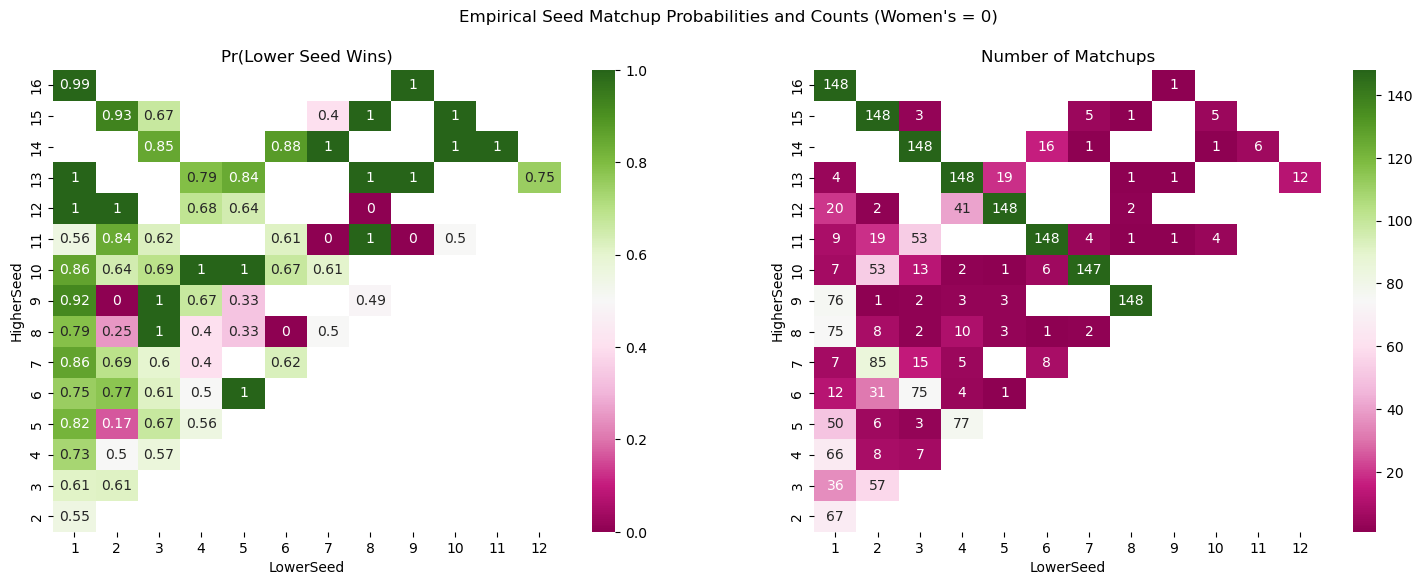

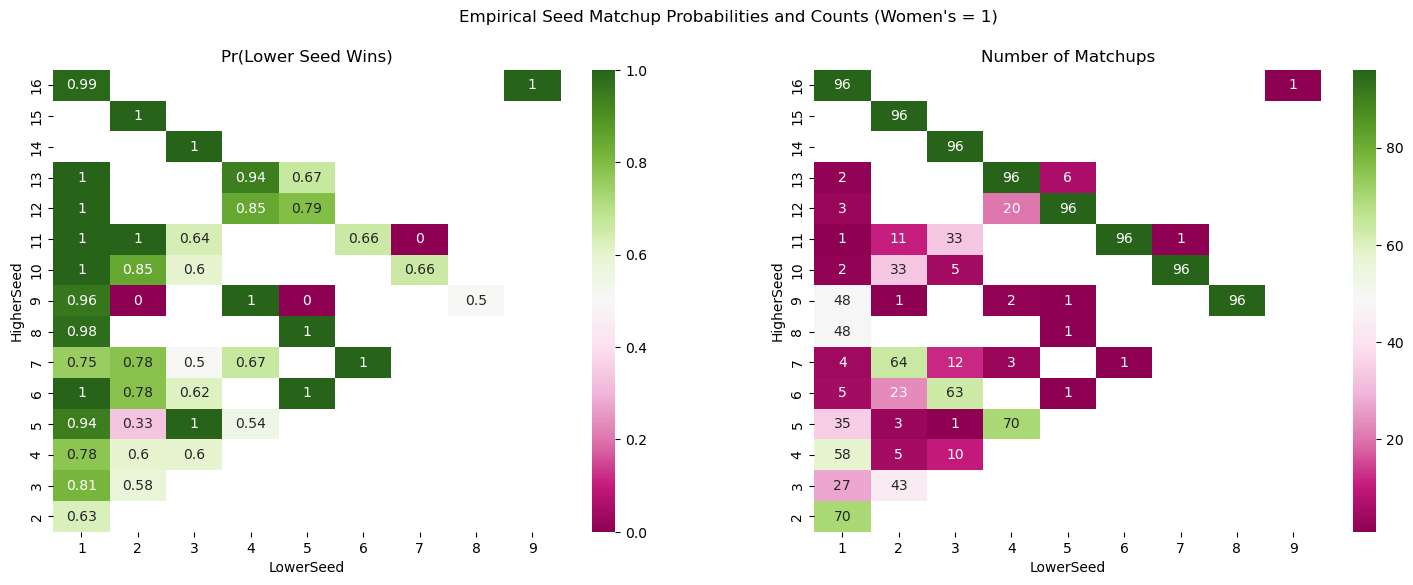

In [8]:
historical_seeds = make_df("NCAATourneySeeds",["Season","Seed","TeamID"], True)
historical_seeds["Female"] = (historical_seeds.Gender == "W").astype(int)
historical_seeds["Seed"] = historical_seeds.Seed.apply(lambda x: int(x[1:-1]) if x[-1] in ["a", "b"] else int(x[1:]))
historical_results = make_df("NCAATourneyCompactResults", ["Season", "WTeamID", "LTeamID"])
historical_results = historical_results.merge(historical_seeds, left_on = ["Season", "WTeamID"], right_on = ["Season", "TeamID"], how="left")
historical_results = historical_results.merge(historical_seeds, left_on = ["Season", "LTeamID"], right_on = ["Season", "TeamID"], how="left", suffixes = ["_Winner", "_Loser"])[["Seed_Winner","Seed_Loser","Female_Winner"]]
historical_results["LowerSeed"] = historical_results[["Seed_Winner","Seed_Loser"]].min(axis=1)
historical_results["HigherSeed"] = historical_results[["Seed_Winner","Seed_Loser"]].max(axis=1)
historical_results["LowerSeedWins"] = historical_results.Seed_Winner == historical_results[["Seed_Winner","Seed_Loser"]].min(axis=1)
probs = pd.DataFrame(historical_results.groupby(["Female_Winner","LowerSeed","HigherSeed"]).agg({"LowerSeedWins": ["count", np.mean]}).reset_index())
probs.columns = list(map("".join, probs.columns.values))
probs["LowerSeedWinsmean"] = np.where(probs.LowerSeed == probs.HigherSeed, 0.5, probs.LowerSeedWinsmean)
for g, d in probs.groupby("Female_Winner"):
    to_plot_1 = d[d.LowerSeed != d.HigherSeed].pivot_table(index="HigherSeed", columns="LowerSeed", values="LowerSeedWinsmean")
    to_plot_2 = d[d.LowerSeed != d.HigherSeed].pivot_table(index="HigherSeed", columns="LowerSeed", values="LowerSeedWinscount")
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
    fig.suptitle(f"Empirical Seed Matchup Probabilities and Counts (Women's = {g})")
    ax1 = sns.heatmap(to_plot_1, annot=True, cmap="PiYG", ax=axs[0])
    ax2 = sns.heatmap(to_plot_2, annot=True, cmap="PiYG", ax=axs[1], fmt="g")
    ax1.title.set_text("Pr(Lower Seed Wins)")
    ax1.invert_yaxis()
    ax2.title.set_text("Number of Matchups")
    ax2.invert_yaxis()

In [9]:
def prob_lookup(low, high, gender,team_predicting_is_lower_seed):
    try:
        prob = probs[(probs.Female_Winner == gender) & (probs.LowerSeed == low) & (probs.HigherSeed == high)]["LowerSeedWinsmean"].values[0]
    except: # for never before seen seed matchups
        prob = 0.5
    if team_predicting_is_lower_seed == 1:
        return prob
    return 1-prob

def get_empirical_probs(arr: np.array):
    lower_seeds = np.min(arr[:,:2], axis=1)
    higher_seeds = np.max(arr[:,:2], axis=1)
    team_predicting_is_lower_seed = np.argmax(arr[:,:2], axis=1)
    genders = arr[:,2]
    inputs = np.stack([lower_seeds, higher_seeds, genders, team_predicting_is_lower_seed], axis=1).tolist()
    return list(map(lambda x: prob_lookup(x[0],x[1],x[2],x[3]), inputs))

We get the brier score by using historical probabilities. Note, this may be a bit artificially since the empirical probabilities are calculated with the validation data included. This is done because I want to use the best probability estimates in the final model.

In [10]:
y_pred = get_empirical_probs(X_val[["SeedLower","SeedHigher","Female"]].to_numpy())
brier_score_loss(y_val, y_pred)

0.1774617700851258

# Neural Net

This dataset is tiny, meaning each training epoch is completed almost instantaneously. Thus, the strategy will be a low learning rate with a large number of epochs with an early stopping rule.

In [11]:
empirical_probs = np.expand_dims(get_empirical_probs(X_train[["SeedLower","SeedHigher","Female"]].to_numpy()), 1)
X_train = preprocessor.fit_transform(X_train)
X_train = np.hstack([X_train, empirical_probs])

empirical_probs = np.expand_dims(get_empirical_probs(X_val[["SeedLower","SeedHigher","Female"]].to_numpy()), 1)
X_val = preprocessor.fit_transform(X_val)
X_val = np.hstack([X_val, empirical_probs])

In [12]:
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1, activation='sigmoid'))


opt = tf.keras.optimizers.Adam(learning_rate=0.000001)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["mse"])
callback = tf.keras.callbacks.EarlyStopping(monitor="val_mse", min_delta=0, patience=500,  restore_best_weights=True)

In [13]:
history = model.fit(X_train, y_train, epochs=50000, batch_size=32, 
                    validation_data=(X_val, y_val),verbose = 0,
                    callbacks = [callback])

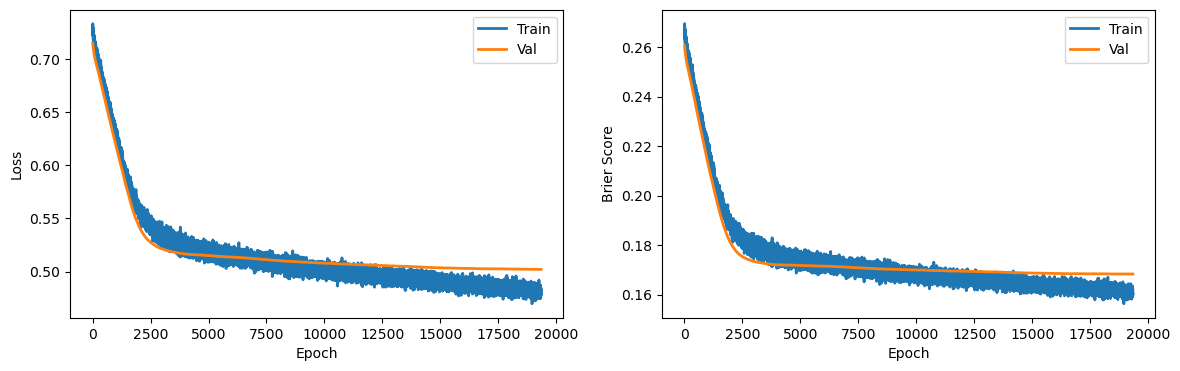

In [14]:
logs = pd.DataFrame(history.history)

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(logs.loc[5:,"loss"], lw=2, label='Train')
plt.plot(logs.loc[5:,"val_loss"], lw=2, label='Val')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(logs.loc[5:,"mse"], lw=2, label="Train")
plt.plot(logs.loc[5:,"val_mse"], lw=2, label="Val")
plt.xlabel("Epoch")
plt.ylabel("Brier Score")
plt.legend()
plt.show()

In [15]:
print(brier_score_loss(y_val, model.predict(X_val)))

13/13 [==============================] - 0s 2ms/step
0.16832545922301154


# Random Forest

In [16]:
rf = RandomForestClassifier(n_estimators = 5000, max_depth=5, random_state=99)
rf.fit(X_train, y_train)
brier_score_loss(y_val, rf.predict_proba(X_val)[:,1])

0.18159059006748354

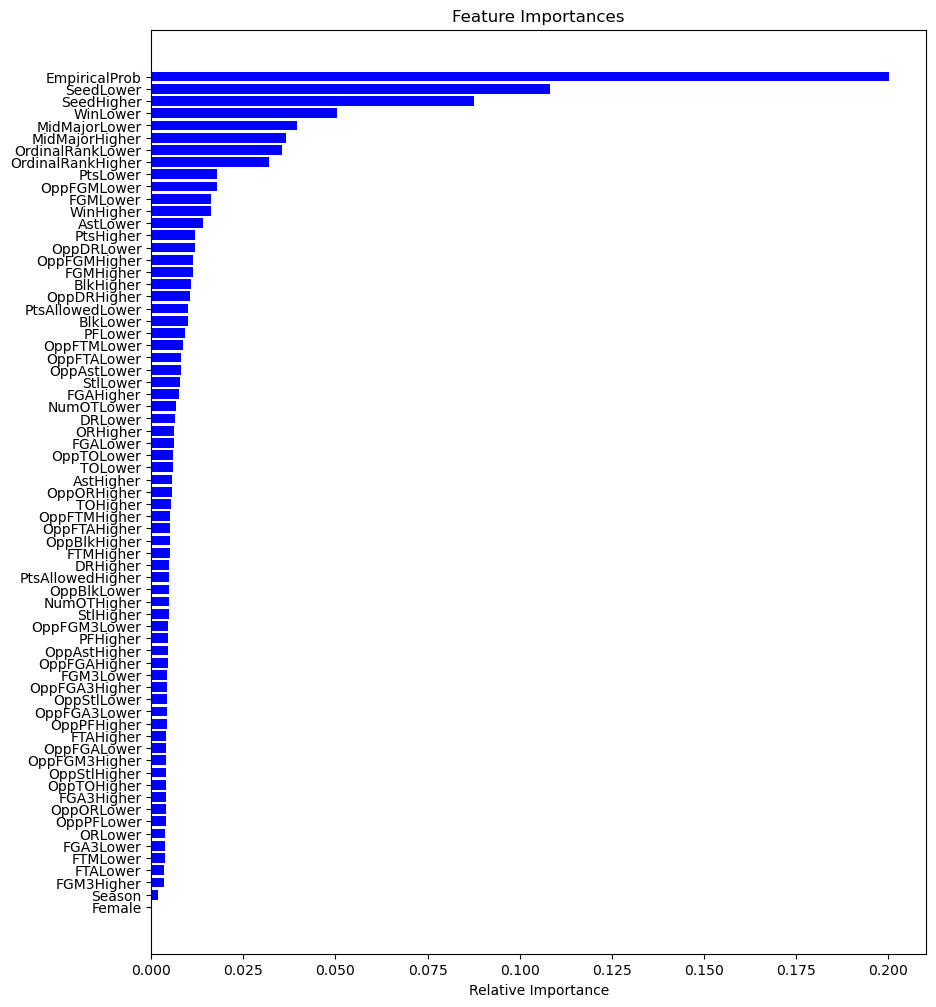

In [17]:
features = list(X.columns) + ["EmpiricalProb"]
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Inference

Ensemble of Empirical Prediction, NN, and RF

In [18]:
matchups = pd.read_csv("/kaggle/input/march-machine-learning-mania-2023/SampleSubmission2023.csv")
matchups["Season"] = matchups.ID.apply(lambda x: int(x.split("_")[0]))
matchups["LowerTeamID"] = matchups.ID.apply(lambda x: int(x.split("_")[1]))
matchups["HigherTeamID"] = matchups.ID.apply(lambda x: int(x.split("_")[2]))
matchups.drop(columns=["ID","Pred"], inplace=True)

In [19]:
X_test = matchups.merge(teams, left_on = "LowerTeamID", right_on = "TeamID").drop(columns = "TeamID")
X_test = double_merge(X_test, tourney_seeds)
X_test = double_merge(X_test, conferences)
X_test = double_merge(X_test, averages_by_season, how="inner") # only train on seasons with detailed data
X_test = double_merge(X_test, massey)
X_test["Female"] = X_test.Gender == "F"
ids = str(2023) + "_" + X_test.LowerTeamID.astype(str) + "_" + X_test.HigherTeamID.astype(str)
X_test.drop(["LowerTeamID","HigherTeamID"], axis = 1, inplace = True)
X_test.drop(columns=["Gender"], inplace=True)
# # women dont have massey, use mean amongst men tournament teams
# # since the datasets are so different, may be better to run separate analyses next time
X_test[["OrdinalRankLower", "OrdinalRankHigher"]] = X_test[["OrdinalRankLower", "OrdinalRankHigher"]].fillna(means)
# ensure columns ordered correctly
X_test = X_test[X.columns]
X_test[["SeedLower","SeedHigher"]] = X_test[["SeedLower","SeedHigher"]].fillna(8) # don't care about non-tourney teams

pred_empirical = np.expand_dims(get_empirical_probs(X_test[["SeedLower","SeedHigher","Female"]].to_numpy()), 1)

X_test = preprocessor.fit_transform(X_test)
X_test = np.hstack([X_test, pred_empirical])

pred_nn = model.predict(X_test)
pred_rf = np.expand_dims(rf.predict_proba(X_test)[:,1], 1)

preds = np.hstack((pred_empirical*0.1, pred_nn*0.8, pred_rf*0.1)).sum(axis=1)

submission = pd.DataFrame({"ID":ids,"Pred":preds})
submission.to_csv("submission.csv", index = False)

4084/4084 [==============================] - 5s 1ms/step


In [20]:
# split back out the matchups for sanity checks
submission["Season"] = submission.ID.apply(lambda x: int(x.split("_")[0]))
submission["LowerTeamID"] = submission.ID.apply(lambda x: int(x.split("_")[1]))
submission["HigherTeamID"] = submission.ID.apply(lambda x: int(x.split("_")[2]))
submission = double_merge(submission, tourney_seeds).dropna()
team_info = make_df("Teams", ["TeamID","TeamName"], True)
submission = submission.merge(team_info, left_on = "LowerTeamID", right_on = "TeamID")
submission = submission.merge(team_info, left_on = "HigherTeamID", right_on = "TeamID", 
                              suffixes = ["Lower","Higher"])
# view some extreme examples
examples = pd.concat([submission.sort_values("Pred", ascending=True).head(10),
           submission.sort_values("Pred", ascending=False).head(10)])

("Prob " + examples.TeamNameLower + " beats " + examples.TeamNameHigher + " (" + examples.GenderHigher +
 "): " + examples.Pred.apply(lambda x: str(round(x, 3)))).values
   

array(['Prob Sacred Heart beats South Carolina (W): 0.021',
       'Prob Monmouth NJ beats South Carolina (W): 0.024',
       'Prob Chattanooga beats South Carolina (W): 0.024',
       'Prob Southern Univ beats Stanford (W): 0.027',
       'Prob Norfolk St beats South Carolina (W): 0.028',
       'Prob Southern Univ beats Virginia Tech (W): 0.031',
       'Prob Howard beats Purdue (M): 0.034',
       'Prob CS Sacramento beats South Carolina (W): 0.034',
       'Prob East Carolina beats South Carolina (W): 0.034',
       'Prob F Dickinson beats Purdue (M): 0.034',
       'Prob Houston beats TX Southern (M): 0.969',
       'Prob South Carolina beats Southern Univ (W): 0.968',
       'Prob South Carolina beats St Louis (W): 0.967',
       'Prob Houston beats SE Missouri St (M): 0.964',
       'Prob South Carolina beats Tennessee Tech (W): 0.962',
       'Prob Houston beats Howard (M): 0.962',
       'Prob South Carolina beats Toledo (W): 0.96',
       'Prob Indiana beats Monmouth NJ (W): 